<a href="https://colab.research.google.com/github/SanghunOh/study_machinglearning/blob/main/codes/sanghunoh/reports/Term_2_CNN_MPIE_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Connect Drive

In [1]:
# path_root = '/content/drive/MyDrive/datas/'
path_root = '/Users/sanghunoh/Develops/repository/own/study_machinglearning/datas'

# 작업 경로 설정
import os
os.chdir(path_root)
!ls

HW3Data_1.mat
HW4_COIL20.mat
HW5Data_1.mat
HW5Data_2.mat
README.md
dataCh4_7.zip
digitimages_binary.zip
iris.zip
mpie_30_shuffle
mpie_30_shuffle.zip
results_CNN_.pickle
results_CNN_label_1_202205301442.pickle
results_CNN_label_2_202205301442.pickle
results_CNN_label_4_202205301442.pickle
results_Finetuning_label_1.csv
results_Finetuning_label_1.png
results_Finetuning_label_1_202205301519.pickle
results_Finetuning_label_2.csv
results_Finetuning_label_2.png
results_Finetuning_label_2_202205301519.pickle
results_Finetuning_label_4.csv
results_Finetuning_label_4.png
results_Finetuning_label_4_202205301519.pickle
results_Finetuning_label_all.csv
results_Finetuning_label_all.png
results_MLP_.pickle
results_MLP_label_0.csv
results_MLP_label_0.png
results_MLP_label_0_202205301020.pickle
results_MLP_label_3.csv
results_MLP_label_3.png
results_MLP_label_3_202205301020.pickle
results_MLP_label_5.csv
results_MLP_label_5.png
results_MLP_label_5_202205301020.pickle
results_MLP_label_all.csv
results_

In [2]:
# config param
file_prefix = 'results_CNN_label_'  # file name
save_file = True  # save graph, csv 
global rank 
rank = 10

In [3]:
import glob

filename_list = []
for file_name in glob.glob(f"./{file_prefix}*.pickle"):
    filename_list.append(file_name)
filename_list

['./results_CNN_label_4_202205301442.pickle',
 './results_CNN_label_1_202205301442.pickle',
 './results_CNN_label_2_202205301442.pickle']

##Load Trained Model

In [4]:
import pickle
results_list = list()
for filename in filename_list:
  with open(filename, 'rb') as f:
    results_list.append(pickle.load(f))
len(results_list)   # model, history, execution_time, _params

2022-06-01 13:45:11.016531: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-01 13:45:11.016826: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



3

##create DataFrame with concate params from results

###결과값을 순서 맞게 나열하기
순서 : params + history values + model layers + training time + history params


In [5]:
import numpy as np
def resultToValueslist(model, history, training_time, params):
  model_layer_depth = [len(model.layers)]
  history_values = list(np.array(list(history.history.values()))[:,-1])
  history_params = list(history.params.values())
  _training_time = [training_time]
  params_values = list(params.values())
  _value_list = params_values + history_values + model_layer_depth + _training_time + history_params
  return _value_list
# value_list

###학습결과값을 DataFrame으로 만들기

In [6]:
# merge column epochs (epochs 컬럼 2개임)
import pandas as pd

def mergeColumnWithepochs(dataframe):
  # dataframe = _dataframe.copy()
  _epochs_temp = dataframe['epochs']
  _epochs_temp = _epochs_temp.iloc[:,0]
  dataframe.drop(labels=['epochs', 'verbose'], axis=1, inplace=True)
  _result_df = pd.concat([dataframe, _epochs_temp],axis=1)
  return _result_df

In [7]:
def valueslistToDataFrame(_result_per_label_list):
  _results_list = list()
  for _results in _result_per_label_list:
    _model, _history, _training_time, _params = _results[0], _results[1], _results[2], _results[3]
    # print(f'Training Time : {_training_time:.3f} sec')
    _results_list.append(resultToValueslist(_model, _history, _training_time, _params))
  _column_name = list(_params.keys())+list(_history.history.keys())+['model_layer_depth','training_time']+list(_history.params.keys())

  # print(f'valueslistToDataFrame : {len(_results_list)}, column_name: {_column_name}')
  _result_df = pd.DataFrame(_results_list, columns=_column_name)
  _result_df = mergeColumnWithepochs(_result_df)

  # loss - val_loss and accuracy - val_accuracy
  _result_df['loss_gap'] = _result_df['loss'] - _result_df['val_loss']
  _result_df['accuracy_gap'] = _result_df['accuracy'] - _result_df['val_accuracy']

  # check rank count
  rows_count = _result_df.shape[0]
  global rank
  if rank >= rows_count:
    rank = rows_count
    print(f'rank : {rank}')
  return _result_df

###label_class 별로 DataFrame을 list 담기

In [8]:
import pandas as pd

results_df_list = list()
for result_per_label_list in results_list:
  results_df_list.append(valueslistToDataFrame(result_per_label_list))

In [9]:
# results_df_list[0]

##Evaluation

###Per Label class

In [10]:
evaluation_columns = ['loss', 'val_loss', 'accuracy', 'val_accuracy', 'loss_gap', 'accuracy_gap']

In [11]:
def sortEvaluationColumns(_results_df):
  _evaluation_df = _results_df.sort_values(evaluation_columns, ascending = [True, False, True, False, True, True])
  print(len(_evaluation_df.columns), _evaluation_df.columns)
  return _evaluation_df

In [12]:
evaluation_df_list = list()
for results_df in results_df_list:
  evaluation_df_list.append(sortEvaluationColumns(results_df))
# evaluation_df


21 Index(['filters', '_padding', '_kernel_initializer', '_activation',
       '_optimizer', 'batch_normal', '_kernel_size', '_strides', 'pool_type',
       '_class_cnt', 'label_class', 'loss', 'accuracy', 'val_loss',
       'val_accuracy', 'model_layer_depth', 'training_time', 'steps', 'epochs',
       'loss_gap', 'accuracy_gap'],
      dtype='object')
21 Index(['filters', '_padding', '_kernel_initializer', '_activation',
       '_optimizer', 'batch_normal', '_kernel_size', '_strides', 'pool_type',
       '_class_cnt', 'label_class', 'loss', 'accuracy', 'val_loss',
       'val_accuracy', 'model_layer_depth', 'training_time', 'steps', 'epochs',
       'loss_gap', 'accuracy_gap'],
      dtype='object')
21 Index(['filters', '_padding', '_kernel_initializer', '_activation',
       '_optimizer', 'batch_normal', '_kernel_size', '_strides', 'pool_type',
       '_class_cnt', 'label_class', 'loss', 'accuracy', 'val_loss',
       'val_accuracy', 'model_layer_depth', 'training_time', 'steps', 'ep

In [13]:
evaluation_df_list_rank = list()
for evaluation_df in evaluation_df_list:
  evaluation_df_list_rank.append(evaluation_df[:rank])

In [14]:
evaluation_df_list_rank[2]

,filters,_padding,_kernel_initializer,_activation,_optimizer,batch_normal,_kernel_size,_strides,pool_type,_class_cnt,...,loss,accuracy,val_loss,val_accuracy,model_layer_depth,training_time,steps,epochs,loss_gap,accuracy_gap
40,16,same,he_normal,relu,Nadam,True,"(3, 3)","(1, 1)",average,5,...,0.005398,0.998669,0.017575,0.997247,8,149.555099,294,30,-0.012177,0.001421
60,16,valid,he_normal,relu,Nadam,True,"(5, 5)","(1, 1)",average,5,...,0.006158,0.998030,0.027489,0.994298,8,141.159568,294,30,-0.021331,0.003731
44,16,same,he_normal,relu,Nadam,True,"(5, 5)","(1, 1)",average,5,...,0.008746,0.997124,0.017751,0.997051,8,149.371002,294,30,-0.009006,0.000073
61,16,valid,he_normal,relu,Nadam,True,"(5, 5)","(1, 1)",max,5,...,0.011133,0.996538,0.031856,0.994495,8,133.779211,294,30,-0.020723,0.002044
56,16,valid,he_normal,relu,Nadam,True,"(3, 3)","(1, 1)",average,5,...,0.011844,0.997071,0.019787,0.996461,8,138.305486,294,30,-0.007943,0.000610
41,16,same,he_normal,relu,Nadam,True,"(3, 3)","(1, 1)",max,5,...,0.012044,0.997071,0.028757,0.994691,8,156.869686,294,30,-0.016713,0.002380
45,16,same,he_normal,relu,Nadam,True,"(5, 5)","(1, 1)",max,5,...,0.012767,0.996219,0.023528,0.993315,8,163.537979,294,30,-0.010761,0.002904
46,16,same,he_normal,relu,Nadam,True,"(5, 5)","(3, 3)",average,5,...,0.013910,0.994621,0.045136,0.986040,8,85.980084,294,30,-0.031226,0.008581
57,16,valid,he_normal,relu,Nadam,True,"(3, 3)","(1, 1)",max,5,...,0.014603,0.997710,0.046696,0.994888,8,147.352540,294,30,-0.032093,0.002822
48,16,valid,he_normal,relu,Nadam,True,"(3, 3)","(1, 1)",average,5,...,0.019590,0.994515,0.016433,0.996658,8,45.184780,294,10,0.003157,-0.002143


###draw evaluation

In [15]:
import matplotlib.pyplot as plt

def drawEvaluation(_evaluation_df, _save_file=False, _label=None):
  plt.rcParams["figure.figsize"] = (15, 5)

  plt.subplot(121)
  _evaluation_df[['loss', 'val_loss']].T.plot(ax=plt.gca())
  plt.grid(axis='y')
  plt.title('loss rate')
  # plt.xticks(rotation=20)

  plt.subplot(122)
  _evaluation_df[['accuracy', 'val_accuracy']].T.plot(ax=plt.gca())
  plt.grid(axis='y')
  # plt.xticks(rotation=20)
  plt.title('accuracy rate')

  _label_class = _label
  if not _label:
    row_name = evaluation_df_rank.index[0]
    _label_class = _evaluation_df.loc[row_name,'label_class']
  
  plt.suptitle(f'label_class : {_label_class}')
  if _save_file:
    _file_name = file_prefix + str(_label_class) + '.png'
    plt.savefig(_file_name)
  plt.show()


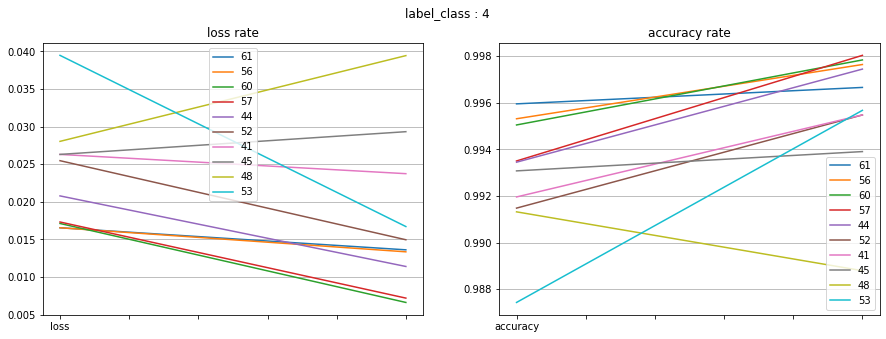

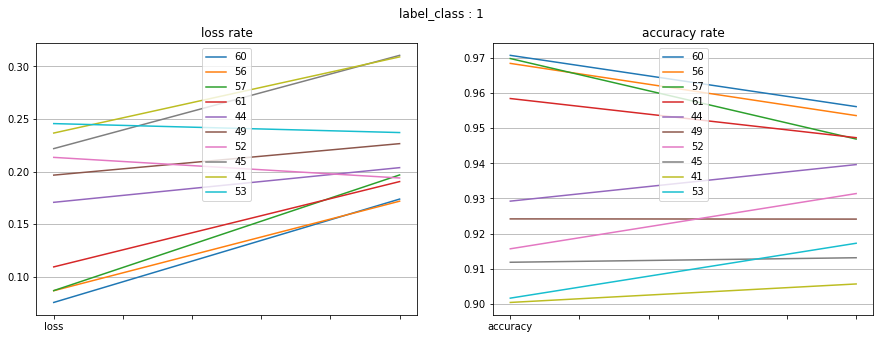

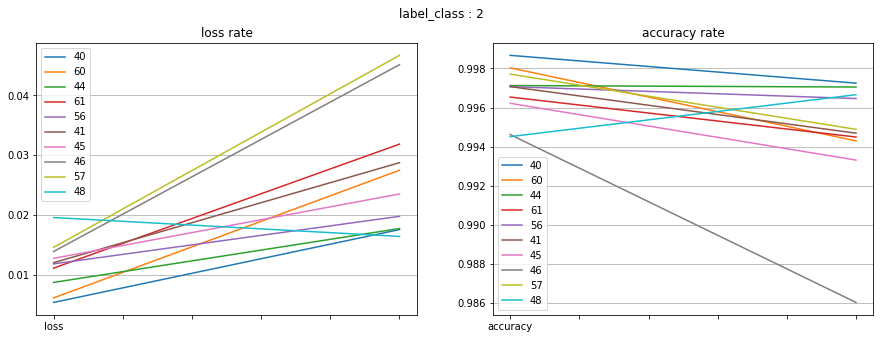

In [16]:
for evaluation_df_rank in evaluation_df_list_rank:
  drawEvaluation(evaluation_df_rank, save_file)


###성능 영향 준 Parameters

In [17]:
def getParametersByPerformance(evaluation_df, _save_file=False, _label=None):
  _evaluation_df = evaluation_df.copy()
  _label_class = _label
  if not _label:
    row_name = evaluation_df_rank.index[0]
    _label_class = _evaluation_df.loc[row_name,'label_class']

  # 성능 영향 없는 컬럼 빼기
  exclusive_columns = evaluation_columns + ['training_time']
  columns_mask_str = _evaluation_df.columns.map(lambda x: True if (x not in exclusive_columns) else False )
  # print(columns_mask_str, len(list(columns_mask_str)))

  # 성능 영향 준 요인이 하나 이상인 컬럼 찾기
  performance_df = _evaluation_df.loc[:,columns_mask_str].value_counts().reset_index()
  performance_df.drop(labels=0, axis=1, inplace=True)
  _measure_columns = list()
  for column in performance_df.columns:
    if len(performance_df[column].unique()) > 1:
      _measure_columns.append(column)
  # print(_measure_columns)

  # 빼었던 컬럼 + 영향 요인 컬럼 합하기
  result_columns = exclusive_columns + _measure_columns
  _evaluation_df = _evaluation_df[result_columns]

  if _save_file:  # 저장 여부
    _file_name = file_prefix + str(_label_class) + '.csv'
    _evaluation_df.to_csv(_file_name)

  return _evaluation_df

In [18]:
performance_params_df_list = list()
for evaluation_df_rank in evaluation_df_list_rank:
  performance_params_df_list.append(getParametersByPerformance(evaluation_df_rank, save_file))
# performance_params_df_list[-1]

In [19]:
performance_params_df_list[0]

,loss,val_loss,accuracy,val_accuracy,loss_gap,accuracy_gap,training_time,_padding,_kernel_size,pool_type,epochs
61,0.016554,0.013622,0.995952,0.996658,0.002932,-0.000705,133.819512,valid,"(5, 5)",max,30
56,0.016556,0.013356,0.995313,0.997641,0.003200,-0.002327,136.191525,valid,"(3, 3)",average,30
60,0.017125,0.006626,0.995047,0.997837,0.010499,-0.002790,133.125973,valid,"(5, 5)",average,30
57,0.017322,0.007204,0.993503,0.998034,0.010118,-0.004531,139.450377,valid,"(3, 3)",max,30
44,0.020791,0.011409,0.993449,0.997444,0.009383,-0.003995,141.985121,same,"(5, 5)",average,30
52,0.025473,0.014961,0.991479,0.995478,0.010512,-0.003999,49.303325,valid,"(5, 5)",average,10
41,0.026305,0.023746,0.991958,0.995478,0.002560,-0.003520,149.292265,same,"(3, 3)",max,30
45,0.026306,0.029327,0.993077,0.993905,-0.003021,-0.000828,153.552638,same,"(5, 5)",max,30
48,0.028040,0.039440,0.991319,0.988793,-0.011400,0.002526,46.854562,valid,"(3, 3)",average,10
53,0.039476,0.016716,0.987431,0.995674,0.022760,-0.008243,49.346327,valid,"(5, 5)",max,10


##Concate All Dataset for Performance

In [20]:
results_df_all = pd.concat(results_df_list).reset_index()
results_df_all.drop(labels='index', axis=1, inplace=True)
results_df_all

,filters,_padding,_kernel_initializer,_activation,_optimizer,batch_normal,_kernel_size,_strides,pool_type,_class_cnt,...,loss,accuracy,val_loss,val_accuracy,model_layer_depth,training_time,steps,epochs,loss_gap,accuracy_gap
0,8,same,he_normal,relu,Nadam,True,"(3, 3)","(1, 1)",average,5,...,0.358149,0.874740,0.268600,0.913685,4,21.018142,294,10,0.089549,-0.038944
1,8,same,he_normal,relu,Nadam,True,"(3, 3)","(1, 1)",max,5,...,0.370829,0.868935,0.277707,0.908769,4,20.933513,294,10,0.093123,-0.039834
2,8,same,he_normal,relu,Nadam,True,"(3, 3)","(3, 3)",average,5,...,0.378166,0.867551,0.260851,0.924302,4,21.688063,294,10,0.117315,-0.056751
3,8,same,he_normal,relu,Nadam,True,"(3, 3)","(3, 3)",max,5,...,0.396764,0.857911,0.341662,0.881636,4,22.512945,294,10,0.055102,-0.023725
4,8,same,he_normal,relu,Nadam,True,"(5, 5)","(1, 1)",average,5,...,0.398943,0.860308,0.294224,0.901494,4,21.423762,294,10,0.104718,-0.041187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,16,valid,he_normal,relu,Nadam,True,"(3, 3)","(3, 3)",max,5,...,0.078288,0.971934,0.103676,0.962839,8,89.614688,294,30,-0.025388,0.009095
188,16,valid,he_normal,relu,Nadam,True,"(5, 5)","(1, 1)",average,5,...,0.006158,0.998030,0.027489,0.994298,8,141.159568,294,30,-0.021331,0.003731
189,16,valid,he_normal,relu,Nadam,True,"(5, 5)","(1, 1)",max,5,...,0.011133,0.996538,0.031856,0.994495,8,133.779211,294,30,-0.020723,0.002044
190,16,valid,he_normal,relu,Nadam,True,"(5, 5)","(3, 3)",average,5,...,0.026397,0.990946,0.058798,0.984271,8,88.740173,294,30,-0.032401,0.006676


In [21]:
evaluation_df_all = sortEvaluationColumns(results_df_all)
evaluation_df_all

21 Index(['filters', '_padding', '_kernel_initializer', '_activation',
       '_optimizer', 'batch_normal', '_kernel_size', '_strides', 'pool_type',
       '_class_cnt', 'label_class', 'loss', 'accuracy', 'val_loss',
       'val_accuracy', 'model_layer_depth', 'training_time', 'steps', 'epochs',
       'loss_gap', 'accuracy_gap'],
      dtype='object')


,filters,_padding,_kernel_initializer,_activation,_optimizer,batch_normal,_kernel_size,_strides,pool_type,_class_cnt,...,loss,accuracy,val_loss,val_accuracy,model_layer_depth,training_time,steps,epochs,loss_gap,accuracy_gap
168,16,same,he_normal,relu,Nadam,True,"(3, 3)","(1, 1)",average,5,...,0.005398,0.998669,0.017575,0.997247,8,149.555099,294,30,-0.012177,0.001421
188,16,valid,he_normal,relu,Nadam,True,"(5, 5)","(1, 1)",average,5,...,0.006158,0.998030,0.027489,0.994298,8,141.159568,294,30,-0.021331,0.003731
172,16,same,he_normal,relu,Nadam,True,"(5, 5)","(1, 1)",average,5,...,0.008746,0.997124,0.017751,0.997051,8,149.371002,294,30,-0.009006,0.000073
189,16,valid,he_normal,relu,Nadam,True,"(5, 5)","(1, 1)",max,5,...,0.011133,0.996538,0.031856,0.994495,8,133.779211,294,30,-0.020723,0.002044
184,16,valid,he_normal,relu,Nadam,True,"(3, 3)","(1, 1)",average,5,...,0.011844,0.997071,0.019787,0.996461,8,138.305486,294,30,-0.007943,0.000610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,16,valid,he_normal,relu,Nadam,True,"(3, 3)","(3, 3)",max,6,...,0.887257,0.676146,0.972245,0.648054,8,88.536294,294,30,-0.084988,0.028093
64,8,same,he_normal,relu,Nadam,True,"(3, 3)","(1, 1)",average,6,...,0.887321,0.683869,0.861892,0.666536,4,20.248584,294,10,0.025428,0.017333
119,16,valid,he_normal,relu,Nadam,True,"(5, 5)","(3, 3)",max,6,...,0.966995,0.658678,0.977319,0.650610,8,29.744422,294,10,-0.010324,0.008069
114,16,valid,he_normal,relu,Nadam,True,"(3, 3)","(3, 3)",average,6,...,1.023037,0.635192,1.030416,0.623280,8,28.595315,294,10,-0.007379,0.011912


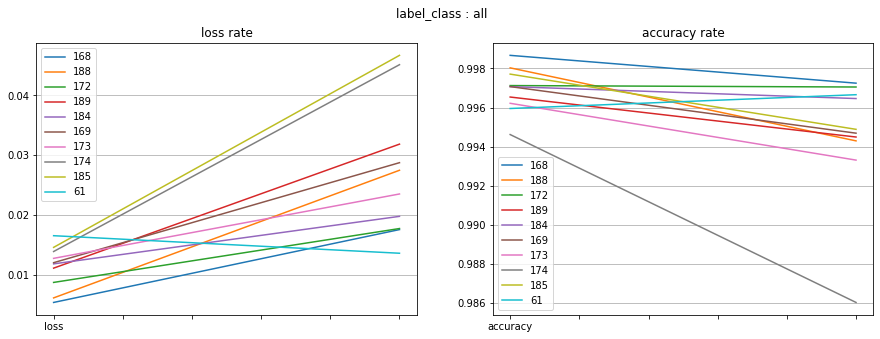

In [22]:
evaluation_df_all_rank = evaluation_df_all[:rank]
drawEvaluation(evaluation_df_all_rank, save_file, _label='all')

In [23]:
getParametersByPerformance(evaluation_df_all_rank, save_file, _label='all')

,loss,val_loss,accuracy,val_accuracy,loss_gap,accuracy_gap,training_time,_padding,_kernel_size,_strides,pool_type,label_class
168,0.005398,0.017575,0.998669,0.997247,-0.012177,0.001421,149.555099,same,"(3, 3)","(1, 1)",average,2
188,0.006158,0.027489,0.998030,0.994298,-0.021331,0.003731,141.159568,valid,"(5, 5)","(1, 1)",average,2
172,0.008746,0.017751,0.997124,0.997051,-0.009006,0.000073,149.371002,same,"(5, 5)","(1, 1)",average,2
189,0.011133,0.031856,0.996538,0.994495,-0.020723,0.002044,133.779211,valid,"(5, 5)","(1, 1)",max,2
184,0.011844,0.019787,0.997071,0.996461,-0.007943,0.000610,138.305486,valid,"(3, 3)","(1, 1)",average,2
169,0.012044,0.028757,0.997071,0.994691,-0.016713,0.002380,156.869686,same,"(3, 3)","(1, 1)",max,2
173,0.012767,0.023528,0.996219,0.993315,-0.010761,0.002904,163.537979,same,"(5, 5)","(1, 1)",max,2
174,0.013910,0.045136,0.994621,0.986040,-0.031226,0.008581,85.980084,same,"(5, 5)","(3, 3)",average,2
185,0.014603,0.046696,0.997710,0.994888,-0.032093,0.002822,147.352540,valid,"(3, 3)","(1, 1)",max,2
61,0.016554,0.013622,0.995952,0.996658,0.002932,-0.000705,133.819512,valid,"(5, 5)","(1, 1)",max,4
